In [150]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from myMLlib import set_seed, rebalance_weight, plt_confusion, plt_loss,load_feather_TS,multi_SA_memwise,BIMHSAttention
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix,  roc_curve, roc_auc_score
import torch
from torch import optim, nn
from torch.utils.data import random_split
import yaml
import os
from numpy.lib.stride_tricks import sliding_window_view
from tqdm.notebook import tqdm  # Import tqdm for progress bar
from enum import Enum

In [151]:
with open('hyperparameters.yml', 'r') as file:
    all_parameters = yaml.safe_load(file)
    parameters = all_parameters['real-blood-meat-time']
materials = parameters['materials']
realmater = parameters['realmater']
dir_path = parameters["dir_path"]
materials = list(materials.values())
print(materials)
print(realmater)

['Vessel', 'Tissue']
['Silicone/Water', 'Silicone']


In [152]:
class Wor():
    def __init__(self,i = None):
        self.a = {0:"_mv",1:""}
        self.i = 0 if i is None else i
        self.data = self.a[self.i]
    def move(self):
        self.i+=1
        if self.i >= 2:
            self.i = 0
        self.data = self.a[self.i]
        return self


In [153]:
name = "/home/yuqster/files/research/dataset/realtest_mwt8/loop-0_Tissue_position-1-18depth_mv.npy"
a = np.load(name)
print(a.shape)

(2, 4096, 1)


In [154]:
seedl = 42
set_seed(seedl)
two_label_depth = []
folderpath = [os.path.join(dir_path,x) for x in ("realtest_mwt7","realtest_mwt8")]
two_data = []
folderloops =  (200, 100)
two_labels = []
for loopnum,folder in zip(folderloops,folderpath):
    data = []
    label_depth = []
    label = []
    for y, mater in enumerate(materials):
        for loop in range(loopnum):
            for position in range(6):
                mv = Wor(1)
                channel = []
                depth_l = []
                for depth in range(16,21):
                    while True:
                        filename = f"loop-{loop}_{mater}_position-{position}-{depth}depth{mv.data}.npy"
                        filepath = os.path.join(folder,filename)
                        signals = np.load(filepath)
                        channel.append(signals)
                        depth_l.append(np.repeat(depth, repeats=signals.shape[0]))
                        mv.move()
                        if mv.i == 0:
                            break
                data.append(np.concatenate(channel,axis=0))
                label.append(y)
                label_depth.append(np.concatenate(depth_l))
    two_data.append(data)
    two_labels.append(label)
    two_label_depth.append(label_depth)


2400
(59, 4096, 1)


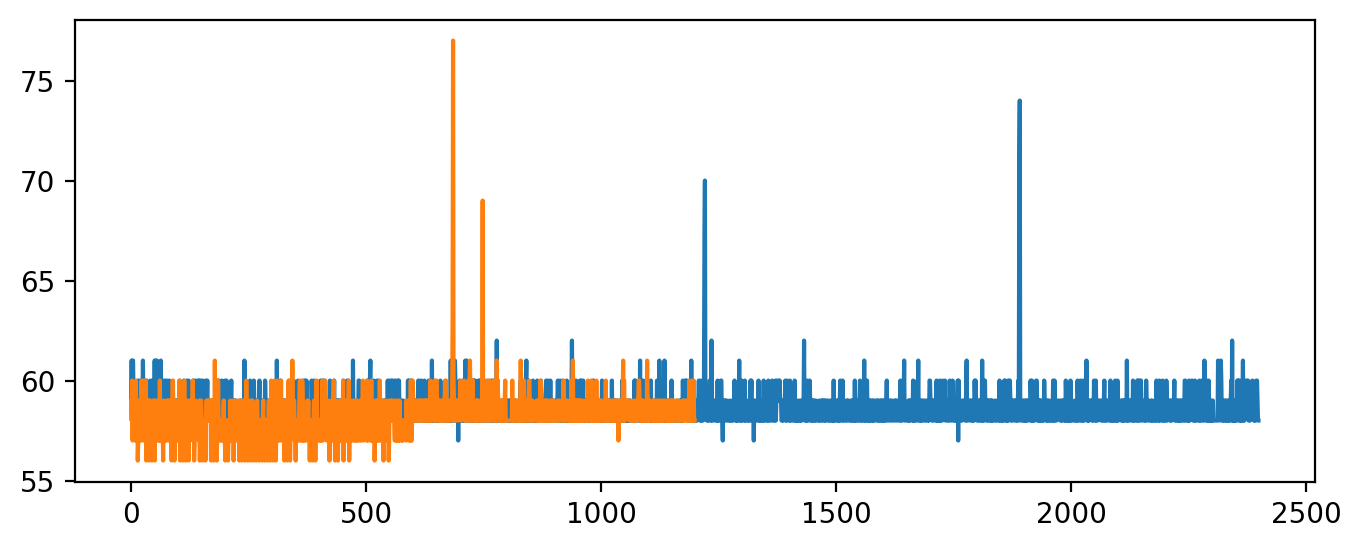

In [264]:
print(len(two_data[0]))
print(two_data[0][2].shape)
plt.figure(dpi=200,figsize=(8,3))
two_shapes = []
for dataset in two_data:
    shapes = []
    for data in dataset:
        shapes.append(data.shape[0])
    plt.plot(shapes)
    two_shapes.append(shapes)

In [265]:
shapelist = two_shapes[0][:600] + two_shapes[0][1200:1800] + two_shapes[1]
shape_test = two_shapes[0][600:1200] + two_shapes[0][1800:]

datalist = two_data[0][:600] + two_data[0][1200:1800] + two_data[1]
data_test = two_data[0][600:1200] + two_data[0][1800:]

depthlist = two_label_depth[0][:600] + two_label_depth[0][1200:1800] + two_label_depth[1]
depthtest = two_label_depth[0][600:1200] + two_label_depth[0][1800:]

labelList =  two_labels[0][:600] + two_labels[0][1200:1800] + two_labels[1]
label_test = two_labels[0][600:1200] + two_labels[0][1800:]

print(len(shapelist))
print(len(shape_test))

print(len(labelList))
print(len(label_test))

print(len(depthlist))
print(len(depthtest))

print(depthlist[0].shape)
print(datalist[0].shape)

2400
1200
2400
1200
2400
1200
(59,)
(59, 4096, 1)


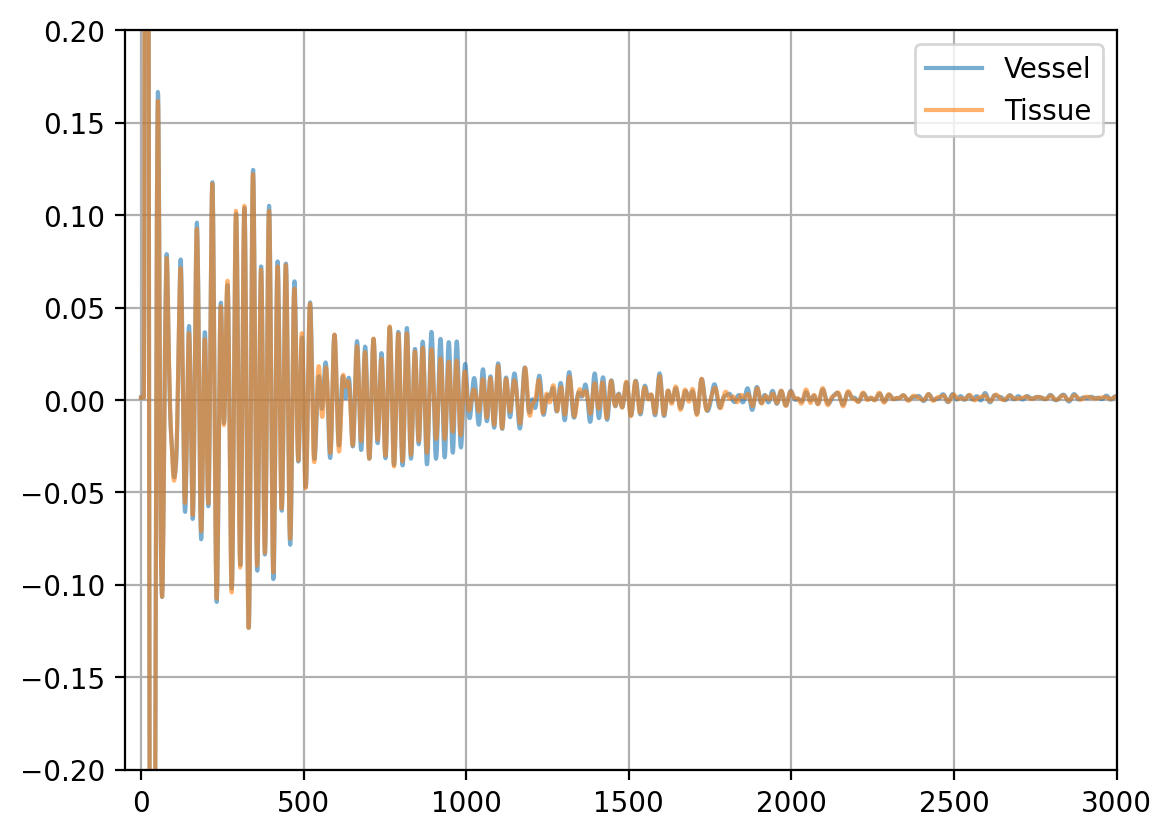

In [266]:
signalV = np.concatenate(datalist[600:1200],axis=0).mean(axis=0)
signalT = np.concatenate(datalist[:600],axis=0).mean(axis=0)
plt.figure(dpi=200)
plt.plot(signalT,alpha=0.6,label=materials[0])
plt.plot(signalV,alpha=0.6,label=materials[1])
plt.ylim((-0.2,0.2))
plt.xlim((-50,3000))
plt.legend()
plt.grid(True)

In [267]:
snapshot = np.concatenate(datalist,axis=0).squeeze()
snapshot_r = np.concatenate(data_test,axis=0).squeeze()
print(snapshot.shape)
print(snapshot_r.shape)
print(len(depthlist))
print(len(depthtest))

(140277, 4096)
(70388, 4096)
2400
1200


In [268]:
# Save
recalculate = False
savefolder = "mwtfiles"
savepathV = os.path.join(savefolder,"mwt_V.npy")
savepathS = os.path.join(savefolder,"mwt_S.npy")
if not os.path.exists(savepathV) or recalculate:
    _, S, Vt = np.linalg.svd(snapshot, full_matrices=False)
    V = Vt.T
    np.save(savepathS, S)
    np.save(savepathV, V)
else:
    S = np.load(savepathS)
    V = np.load(savepathV)

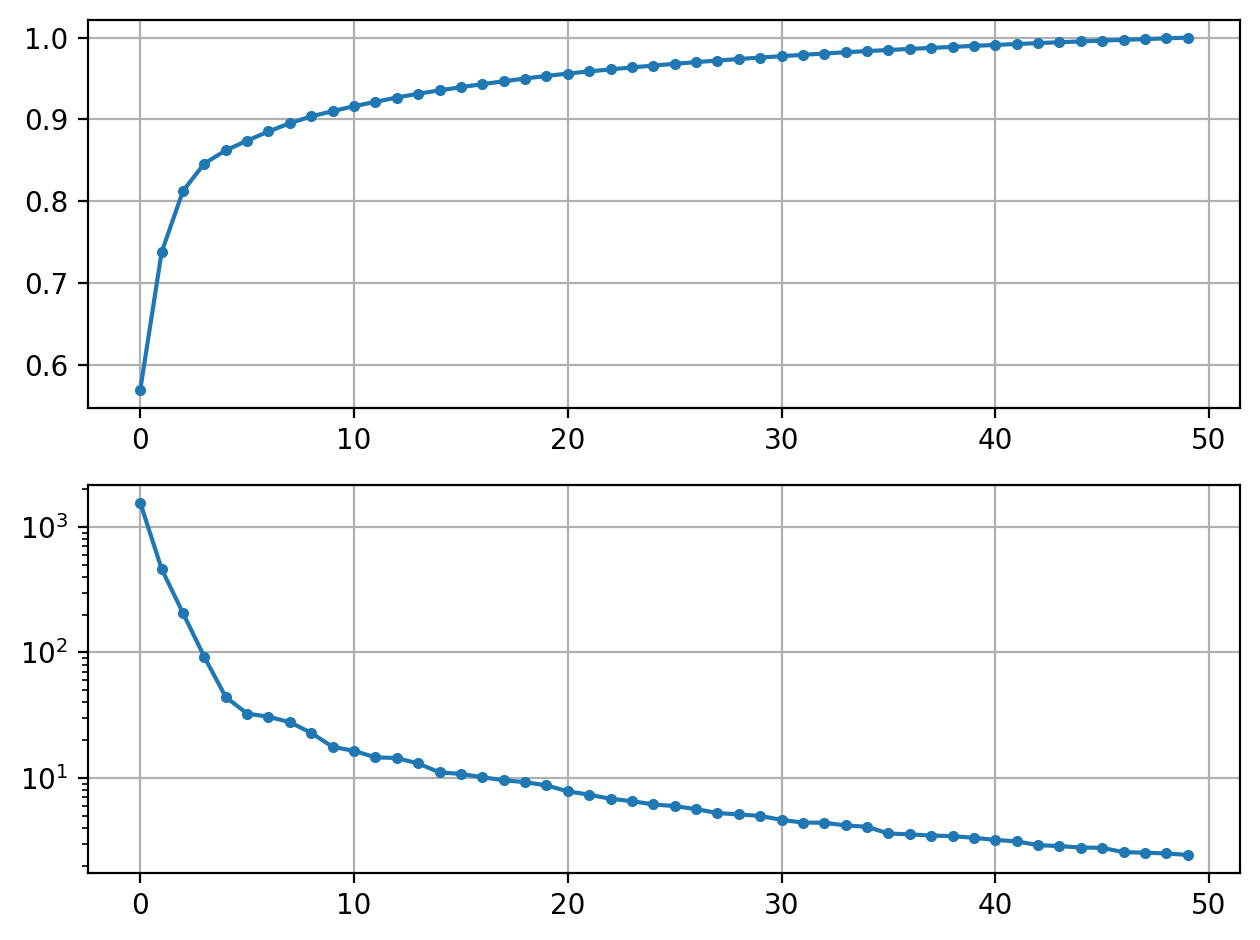

In [269]:
s = 50
energy = np.cumsum(S[:s])/np.sum(S[:s])
plt.figure(dpi=200)
plt.subplot(211)
plt.plot(energy,marker = 'o',linestyle='-',markersize = 3)
plt.grid(True)
plt.subplot(212)
plt.semilogy(S[:s],marker = 'o',linestyle='-',markersize = 3)
plt.grid(True)
plt.tight_layout()

In [270]:
r = 32
Vr = V[:,:r]
print(Vr.shape)

(4096, 32)


In [271]:
Xpp = snapshot @ Vr
X_rpp = snapshot_r @ Vr
print(Xpp.shape)
print(X_rpp.shape)

(140277, 32)
(70388, 32)


In [272]:
scaler = StandardScaler()

Xp = scaler.fit_transform(Xpp)
X_rp = scaler.transform(X_rpp)

In [273]:
def indices(shapelist):
    i = 0
    for shape in shapelist:
        yield list(range(i,i+shape))
        i = i+shape

In [274]:
channelist = []
channelist_r = []
for ind in indices(shapelist):
    data = Xp[ind]
    channelist.append(data)
for ind in indices(shape_test):
    data = X_rp[ind]
    channelist_r.append(data)
print(len(channelist))
print(len(channelist_r))
print(channelist[0].shape)

2400
1200
(59, 32)


In [275]:
swlist = []
swlist_r = []
ylist = []
y_rlist = []
y_depth_list = []
y_r_depth_list = []
win = 8
for channel,label, depth in zip(channelist,labelList,depthlist):
    data = sliding_window_view(channel, axis=0, window_shape=win).transpose(0,2,1)
    depth_data = depth[win-1:]
    y = np.full(data.shape[0], label, dtype=int)
    swlist.append(data)
    ylist.append(y)
    y_depth_list.append(depth_data)
for channel,label, depth in zip(channelist_r,label_test,depthtest):
    data = sliding_window_view(channel, axis=0, window_shape=win).transpose(0,2,1)
    depth_data = depth[win-1:]
    y = np.full(data.shape[0], label, dtype=int)
    swlist_r.append(data)
    y_rlist.append(y)
    y_r_depth_list.append(depth_data)

X = np.concatenate(swlist, axis=0)
X_r = np.concatenate(swlist_r, axis=0)
y_class = np.concatenate(ylist)
y_r_class = np.concatenate(y_rlist)
y_depth = np.concatenate(y_depth_list)
y_r_depth = np.concatenate(y_r_depth_list)
y = np.stack((y_class,y_depth),axis=1)
y_r = np.stack((y_r_class,y_r_depth),axis=1)
print(X.shape)
print(X_r.shape)
print(y_class.shape)
print(y_r_class.shape)
print(y_depth.shape)
print(y_r_depth.shape)
print(y.shape)
print(y_r.shape)

(123477, 8, 32)
(61988, 8, 32)
(123477,)
(61988,)
(123477,)
(61988,)
(123477, 2)
(61988, 2)


(123477, 32)


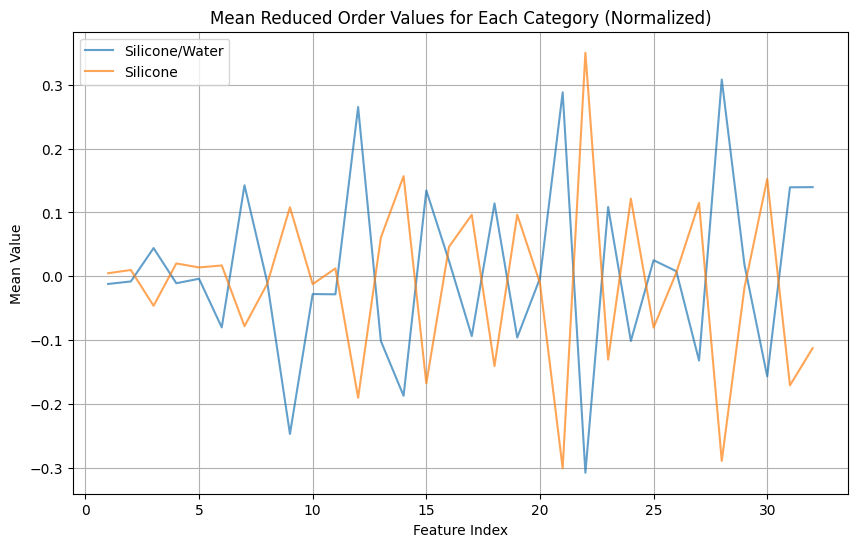

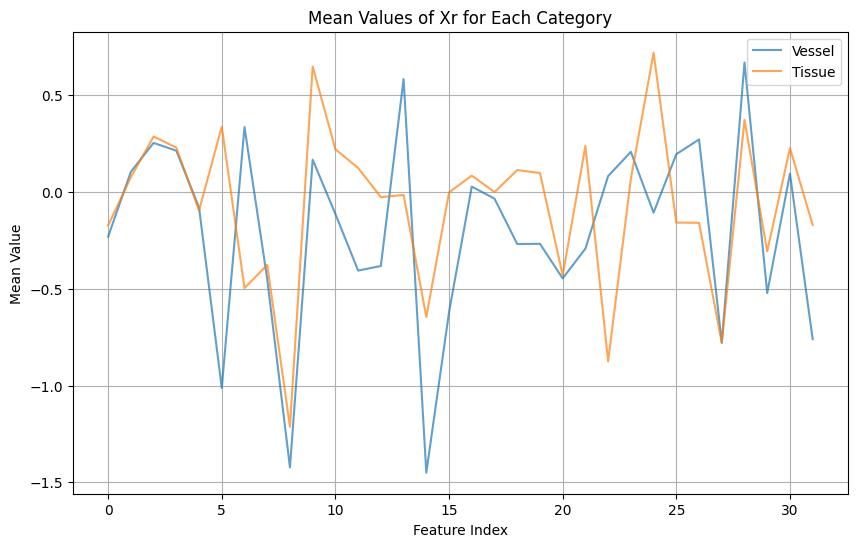

In [276]:
indices1 = {}
indices2 = {}
unique_labels = np.unique(y_class)
length = 2000
Xprint = np.concatenate((X[:length,0,:],X[length:,0,:]),axis=0)
X_rprint = np.concatenate((X_r[:length,0,:],X_r[length:,0,:]),axis=0)
print(Xprint.shape)
yb = np.concatenate((y_class[:length],y_class[length:]))
y_rb = np.concatenate((y_r_class[:length],y_r_class[length:]))
plt.figure(figsize=(10,6))
for i,label in enumerate(unique_labels):
    # 获取当前类别下的样本索引
    indices1[materials[i]] = np.where(yb.flatten() == label)
    # 计算当前类别 X 中所有样本的特征均值（按列均值）
    mean_values = Xprint[indices1[materials[i]]].mean(axis=0)
    # 绘制均值曲线
    plt.plot(range(1, mean_values.shape[0] + 1), mean_values, label=f"{realmater[int(label)]}", alpha=0.7)
plt.xlabel("Feature Index")
# plt.xlim([1,36])
plt.ylabel("Mean Value")
plt.title("Mean Reduced Order Values for Each Category (Normalized)")
plt.legend()
plt.grid(True)

plt.figure(figsize=(10,6))
for i,label in enumerate(unique_labels):
    # 获取当前类别下的样本索引
    indices2[materials[i]] = np.where(y_rb.flatten() == label)
    # 计算当前类别 X 中所有样本的特征均值（按列均值）
    mean_values = X_rprint[indices2[materials[i]]].mean(axis=0) # type: ignore
    # 绘制均值曲线
    plt.plot(mean_values, label=f"{materials[i]}",alpha = 0.7)
plt.xlabel("Feature Index")
plt.ylabel("Mean Value")
plt.title("Mean Values of Xr for Each Category")
plt.legend()
plt.grid(True)



In [277]:
X_ver,X_te,y_ver,y_te = train_test_split(X_r, y_r, test_size=0.5,shuffle=True)
print(X_ver.shape)
print(y_ver.shape)

(30994, 8, 32)
(30994, 2)


In [278]:
device = torch.device(
    "cuda" if torch.cuda.is_available() 
    else "mps" if (hasattr(torch.backends, "mps") and torch.backends.mps.is_available()) 
    else "cpu"
)
print("Using device:", device)

Using device: cuda


In [364]:
class TinyClassifier(nn.Module):
    def __init__(self, vec_dim=64, num_heads=4, num_classes=2, dropout = 0.001, attn_dropout=0.001):
        super().__init__()
        self.attn = BIMHSAttention(vec_dim, num_heads, attn_dropout=attn_dropout, proj_dropout=0)
        self.ln = nn.LayerNorm(vec_dim)
        self.classifier = nn.Sequential(
            nn.Linear(vec_dim,16),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(16,num_classes)
        )
        self.regression = nn.Sequential(
            nn.Linear(vec_dim+num_classes,12),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(12,1)
        )
        # MLP([vec_dim,24,num_classes], actfunc='GELU')

    def forward(self,x):  # token_ids: (B, T)
        x = self.attn(x)                   # (B, C)  q/k/v are produced & used here
        x = self.ln(x)

        logits = self.classifier(x)               # (B, num_classes)
        added = torch.cat((logits,x),dim=1)
        depth = self.regression(added).squeeze(-1)
        return logits, depth

In [365]:
X_train_tensor = torch.tensor(X, dtype=torch.float32).to(device)
cls_y_train_tensor = torch.tensor(y[:,0], dtype=torch.long).squeeze().to(device)
reg_y_train_tensor = torch.tensor(y[:,1], dtype=torch.float32).squeeze().to(device)

X_ver_tensor = torch.tensor(X_ver, dtype=torch.float32).to(device)
cls_y_ver_tensor = torch.tensor(y_ver[:,0], dtype=torch.long).squeeze().to(device)
reg_y_ver_tensor = torch.tensor(y_ver[:,1], dtype=torch.float32).squeeze().to(device)

X_te_tensor = torch.tensor(X_te, dtype=torch.float32).to(device)
cls_y_te_tensor = torch.tensor(y_te[:,0], dtype=torch.long).squeeze().to(device)
reg_y_te_tensor = torch.tensor(y_te[:,1], dtype=torch.float32).squeeze().to(device)


idx = torch.randperm(X_train_tensor.size(0))  # 随机打乱索引
X_train_tensor = X_train_tensor[idx]
cls_y_train_tensor = cls_y_train_tensor[idx]
reg_y_train_tensor = reg_y_train_tensor[idx]
print(X_train_tensor.shape)
print(cls_y_train_tensor.shape)
print(X_te_tensor.shape)
print(reg_y_te_tensor.shape)

torch.Size([123477, 8, 32])
torch.Size([123477])
torch.Size([30994, 8, 32])
torch.Size([30994])


In [366]:
print(y[0])
print(cls_y_train_tensor[0])
print(reg_y_train_tensor[1])

[ 0 16]
tensor(1, device='cuda:0')
tensor(17., device='cuda:0')


In [367]:
seed = 42
set_seed(seed)
numhead = 4
dropout = 0.0
model = TinyClassifier(X.shape[-1],num_classes=2,num_heads=numhead,dropout=dropout, attn_dropout=0.001).to(device)
# class_weights,_ = rebalance_weight(y[:,0])
classif_cri = nn.CrossEntropyLoss() #weight=class_weights.to(device)
regression_cri = nn.MSELoss()
learning_rate = 3e-5
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
reg_wei = 0.005
cla_wei = 1 - reg_wei

In [368]:
train_losses = []
verify_losses = []
num_epochs=10500
pbar = tqdm(range(int(num_epochs)), desc="Training", leave=True)
for epoch in pbar:
    model.train()
    optimizer.zero_grad()
    logits, depth = model(X_train_tensor)      # 解包更清晰
    claloss = classif_cri(logits, cls_y_train_tensor)              # 分类
    reloss  = regression_cri(depth, reg_y_train_tensor) # 回归
    loss = cla_wei*claloss + reg_wei*reloss
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    # —— 2. 验证 —— #
    model.eval()
    with torch.no_grad():
        verify_logits, verify_depth = model(X_ver_tensor)

        verify_claloss = classif_cri(verify_logits, cls_y_ver_tensor)
        verify_reloss  = regression_cri(verify_depth, reg_y_ver_tensor)
        cla = cla_wei*verify_claloss.item()
        reg = reg_wei*verify_reloss.item()
        add = cla + reg
        verify_losses.append([cla, reg, add])

    # —— 3. 更新 tqdm 的显示 —— #
    pbar.set_postfix(
        train_loss = loss.item(),
        class_loss = cla,
        rgs_loss   = reg,
        add_loss   = add
    )

Training:   0%|          | 0/10500 [00:00<?, ?it/s]

In [369]:
# Evaluate the model
model.eval()
with torch.no_grad():
    te_logits, te_depth = model(X_te_tensor)
    tr_logits, tr_depth = model(X_train_tensor)

    # 预测类别（按类别维度 argmax）
    _, predicted       = torch.max(te_logits, 1)
    _, predicted_train = torch.max(tr_logits, 1)

    # 转成 numpy
    predicted_np       = predicted.cpu().numpy()
    predicted_train_np = predicted_train.cpu().numpy()

    cls_y_train_np = cls_y_train_tensor.cpu().numpy()
    cls_y_te_np    = cls_y_te_tensor.cpu().numpy()  

    reg_y_train_np = reg_y_train_tensor.cpu().numpy()
    reg_y_te_np    = reg_y_te_tensor.cpu().numpy()  

    # 训练集准确率
    accuracy_train = accuracy_score(cls_y_train_np, predicted_train_np)

    # 测试集准确率 & 混淆矩阵
    accuracy = accuracy_score(cls_y_te_np, predicted_np)
    cm       = confusion_matrix(cls_y_te_np, predicted_np)


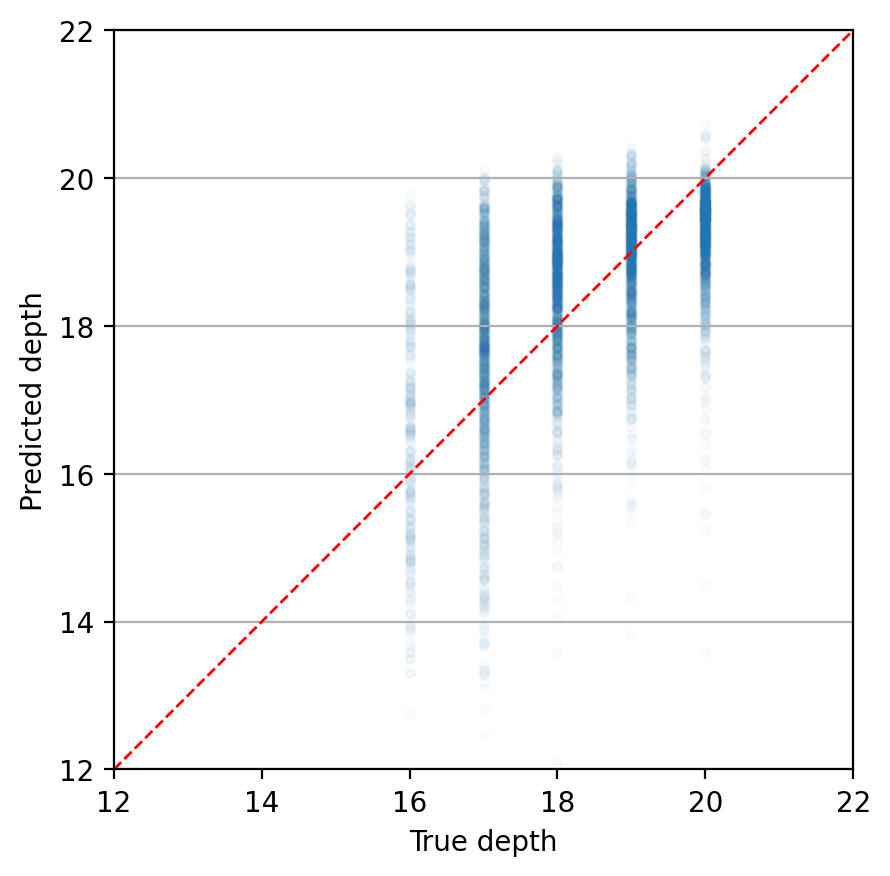

In [370]:
te_depth_np = te_depth.cpu().numpy()
# tr_depth_np = tr_depth.cpu().numpy()
num = 5000

dep_np, reg_np = te_depth_np[:num], reg_y_te_np[:num]

plt.figure(dpi=200)
plt.scatter(reg_np, dep_np, s=10, alpha=0.02)

min_val = 12
max_val = 22
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=1)

plt.xlim((min_val, max_val))
plt.ylim((min_val, max_val))

ax = plt.gca()
ax.set_aspect('equal', adjustable='box')   # 只改比例，不重算 limits

plt.xlabel("True depth")
plt.ylabel("Predicted depth")
plt.grid(axis='y')
plt.show()


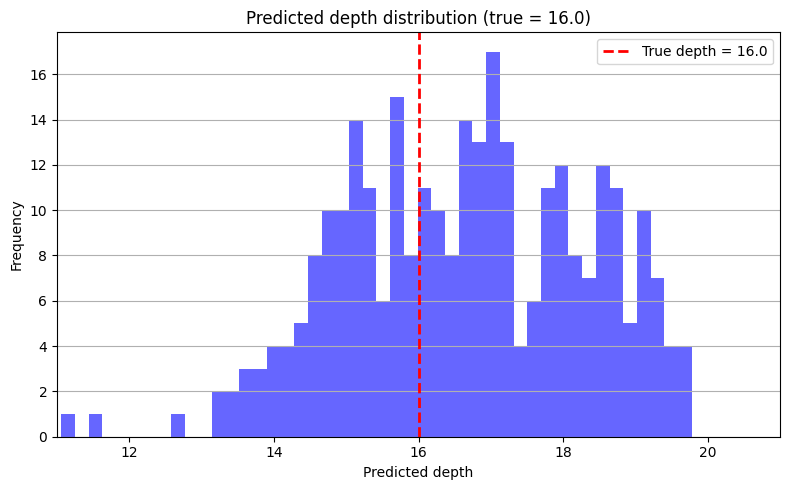

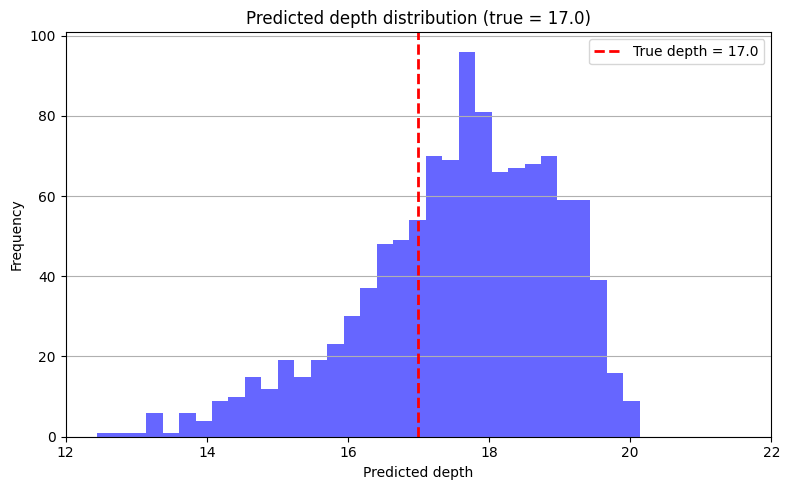

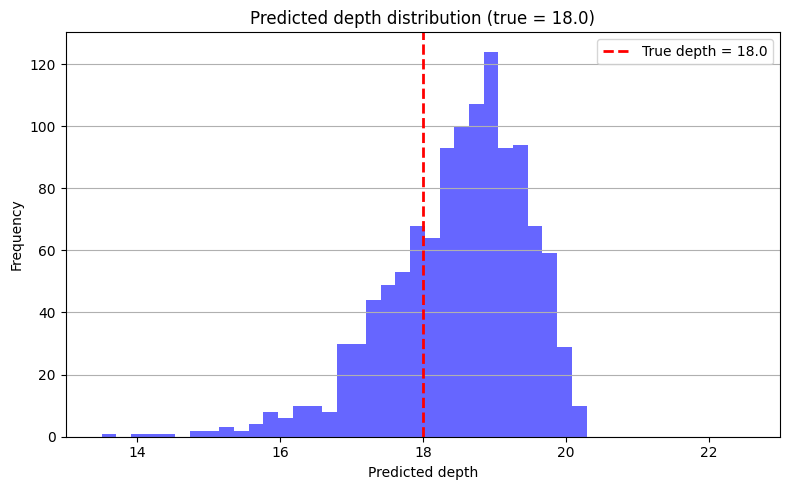

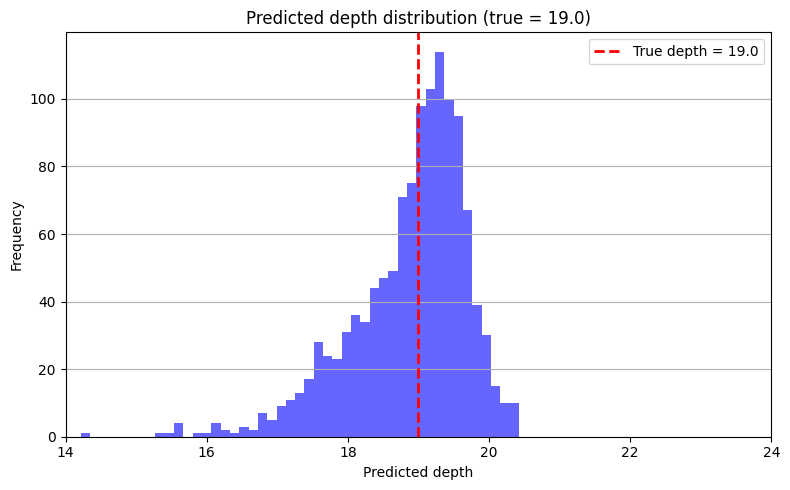

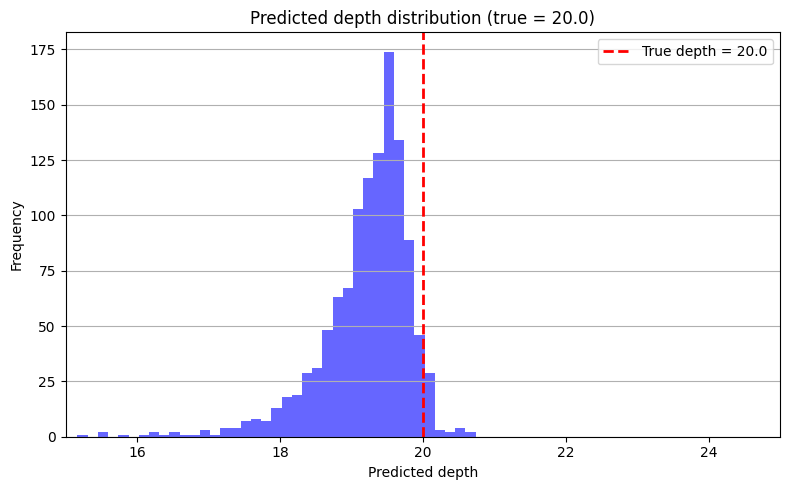

In [375]:
labels = np.unique(reg_np)
mask   = labels[:, None] == reg_np[None, :]   # (K, N)

for lab, ma in zip(labels, mask):
    plt.figure(figsize=(8, 5))
    # 该真实标签下的预测深度
    vals = dep_np[ma]

    plt.hist(vals, bins=50, color='blue', alpha=0.6)

    # 画一条真实深度的竖直线
    plt.axvline(lab, color='red', linestyle='--', linewidth=2,
                label=f"True depth = {lab}")

    # 让真实标签大致居中（可按需要调 delta）
    delta = 5  # 比如左右各 2 单位
    plt.xlim(lab - delta, lab + delta)

    plt.xlabel("Predicted depth")
    plt.ylabel("Frequency")
    plt.title(f"Predicted depth distribution (true = {lab})")
    plt.grid(True, axis='y')
    plt.legend()
    plt.tight_layout()
    plt.show()


0.9995059808709315
0.8628766858101568


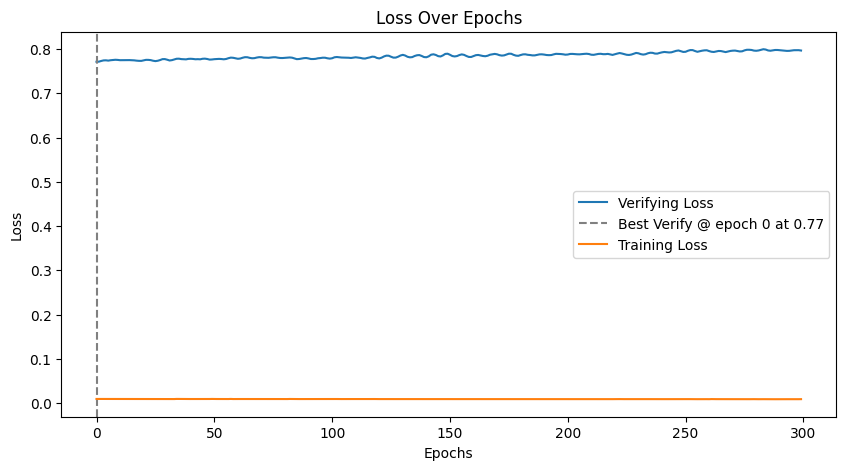

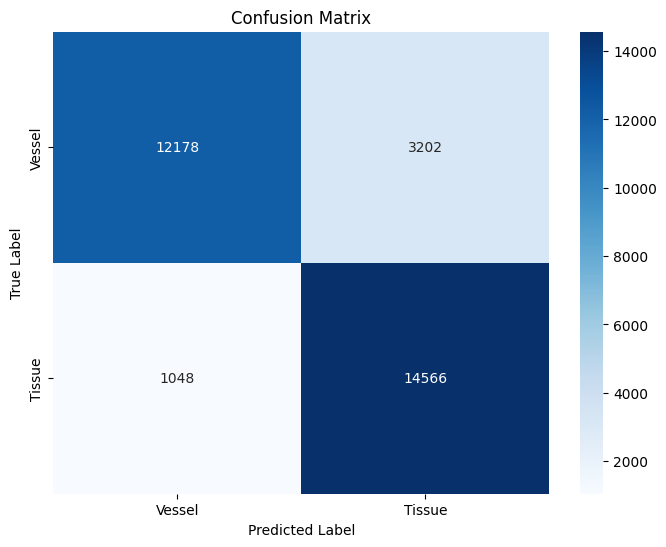

In [ ]:
print(accuracy_train)
print(accuracy)
cls_ver, *_ = zip(*verify_losses)
plt_loss(train_losses=train_losses,verifying_losses=cls_ver)
plt_confusion(cm, materials)

text = f"seedl = {seedl}, seed = {seed}, r = {r}, reg_wei = {reg_wei}, atthead = {numhead}, \
win = {win}, dropout = {dropout}, learning_rate = {learning_rate}, accuracy = {accuracy}\n"
with open("mwtfiles/para.txt","a") as f:
    f.write(text)

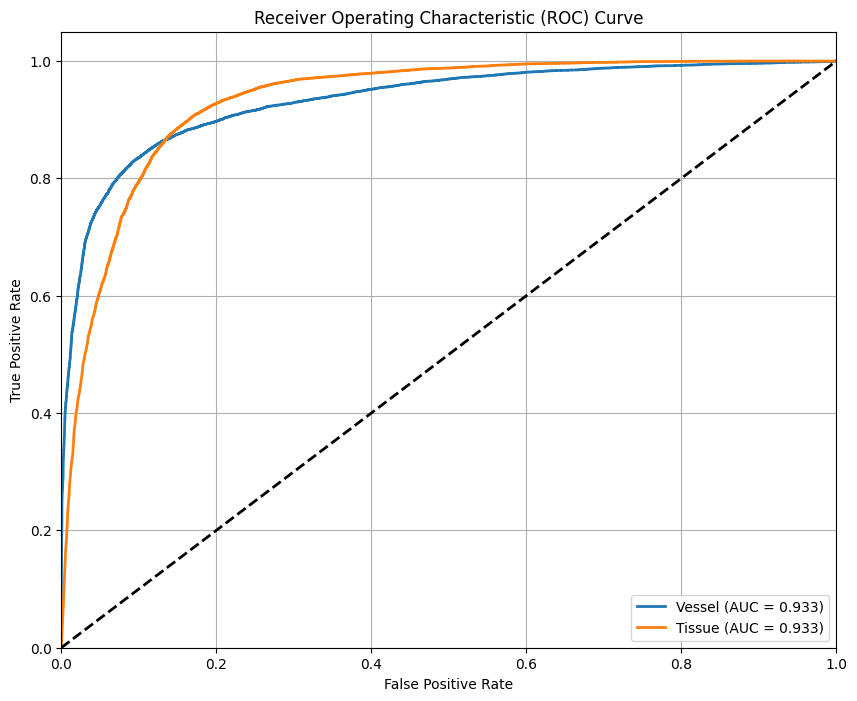

In [ ]:
model.eval()
with torch.no_grad():
    logits, _ = model(X_te_tensor.to(device))    # [N,2]
    # 方法 A：用 softmax 概率
    probs = torch.softmax(logits, dim=1)           # [N, 2]
# One-vs-rest approach for ROC curves
n_classes = len(materials)  
fpr = {}
tpr = {}
roc_auc = {}

# Get prediction probabilities for each class
probs_np = probs.cpu().numpy()

# Calculate ROC curve and ROC area for each class
for i, class_name in enumerate(materials):
	# Convert to binary classification: current class vs rest
	y_binary = (cls_y_te_np.flatten() == i).astype(int)
	fpr[class_name], tpr[class_name], _ = roc_curve(y_binary, probs_np[:, i])
	roc_auc[class_name] = roc_auc_score(y_binary, probs_np[:, i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for class_name in materials:
	plt.plot(fpr[class_name], tpr[class_name], lw=2,
			 label=f'{class_name} (AUC = {roc_auc[class_name]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()